# DDW TASK 2

## Contribution
- Jia Hui - Brainstormed on features, researching, model experimenting
- Pei Xuan - Brainstormed on features, researching, data cleaning
- Min Khant - Brainstormed on features, researching

## Problem Statement

We aim to predict the number of ICU admissions using:

1. Number of days from the introduction of Delta variant
2. Measurement of visitors to transit areas

## Link to Data Sources
### 
*Number of ICU Admission for United kingdom*
- [ICU Admissions](https://coronavirus.data.gov.uk/details/healthcare)

*Number of Covid Cases for United kingdom*
- [Covid Cases 'owid-covid-data.csv'](https://github.com/owid/covid-19-data/tree/master/public/data)

## Cleaning of Data
*Took data from 30/4/2021 to 8/11/2021*

## All possible models
1. **[Linear Regression](#linear)**
2. **[Polynomial Regression](#poly)**
1. **[Mutiple Regression](#multi)**

## Required Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Functions

In [26]:
def normalize_z(df):
    # mean with axis 0 is summing the rows
    return (df - df.mean(axis=0)) / df.std(axis=0) 

def get_features_targets(df, feature_names, target_names):
    ### BEGIN SOLUTION
    df_feature = df[feature_names]
    df_target = df[target_names]
    ### END SOLUTION
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns) 
    feature = df_feature.to_numpy()
    number_of_samples = feature.shape[0]
    return np.concatenate((np.ones((number_of_samples,1)), feature), axis=1)

def prepare_target(df_target):
    # to_numpy() removes the first column (header column)
    return df_target.to_numpy()

def predict(df_feature, beta):
    X = prepare_feature(normalize_z(df_feature))
    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    ### BEGIN SOLUTION
    # get the indexes of the feature 
    indexes = df_feature.index
    # seed the random value 
    if random_state != None:
        np.random.seed(random_state)
    # get the number of test samples to extract 
    k = int(test_size * len(indexes))
    # get the indexes from the features and target to select as test set 
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    ### END SOLUTION
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
  
def r2_score(y, ypred):
    sum_res = np.sum((y - ypred)**2)
    error_tot = y - np.mean(y)
    sum_tot = np.sum(error_tot**2)
    return 1-(sum_res/sum_tot)

def mean_squared_error(target, pred):
    n = target.shape[0]
    return 1/n * np.sum((target-pred)**2)

def compute_cost(X, y, beta):
    J = 0
    
    no_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error) # .T is transpose
    # print(error)
    J = 1/(2*no_of_samples) * error_sq
    return J[0][0]

def gradient_descent(X, y, beta, alpha, num_iters):
    ###
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        # STEP 2: compute the derivate with current parameters
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # STEP 3: update the parameters
        beta = beta - alpha *  derivative_error
        # compute cost at every iteration of beta
        J_storage.append(compute_cost(X, y, beta))
    ### END SOLUTION
    return beta, J_storage

def transform_features_power(df_feature, colname, colname_transformed, value):
    df_feature[colname_transformed] = df_feature[colname]**value
    return df_feature

def add_feature(df_feature, colname_transformed, value):
    df_feature[colname_transformed] = value
    return df_feature

## Reading data from CSV

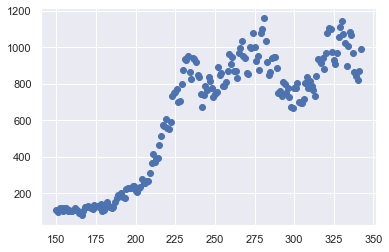

In [27]:
df = pd.read_csv("DDW_dataset1.csv")
df_feature, df_target = get_features_targets(df,["Delta"],["ICU admissions"])

plt.scatter(df_feature, df_target)

**Why number of ICU Admissions were used**

## Linear Regression
<a id="linear"></a>

[[608.34541567]
 [318.79725651]]


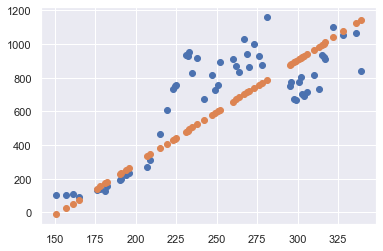

In [28]:
# split data using random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

print(beta)
pred = predict(df_features_test, beta)
# print(pred)

sns.set()
plt.scatter(df_features_test["Delta"], df_target_test)
plt.scatter(df_features_test["Delta"], pred)

In [29]:
# TESTS
target = prepare_target(df_target_test)
r2 = r2_score(target, pred)
print(r2, "r2")

mse = mean_squared_error(target, pred)
print(mse, "mean squared error")


0.5530687395575833 r2
44063.36261961669 mean squared error


## Polynomial Linear Regression
<a id="poly"></a>

     Delta  Delta^2   Delta^3
0      150    22500   3375000
1      151    22801   3442951
2      152    23104   3511808
3      153    23409   3581577
4      154    23716   3652264
..     ...      ...       ...
188    338   114244  38614472
189    339   114921  38958219
190    340   115600  39304000
191    341   116281  39651821
192    342   116964  40001688

[193 rows x 3 columns]


C:\Users\jiahu\AppData\Local\Temp/ipykernel_16280/3108061555.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature[colname_transformed] = df_feature[colname]**value


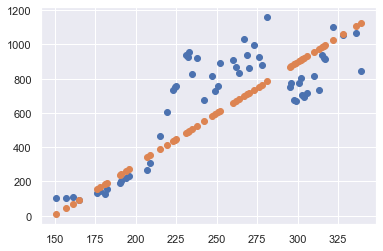

In [30]:
df_features_second = transform_features_power(df_feature, 'Delta', 'Delta^2', 2)
df_features_second = transform_features_power(df_feature, 'Delta', 'Delta^3', 3)
print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# print(beta)
pred = predict(df_features_test, beta)
# print(pred)

sns.set()
plt.scatter(df_features_test["Delta"], df_target_test)
plt.scatter(df_features_test["Delta"], pred)


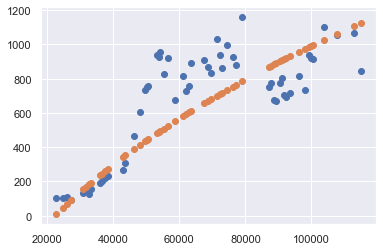

In [31]:
plt.scatter(df_features_test["Delta^2"], df_target_test)
plt.scatter(df_features_test["Delta^2"], pred)

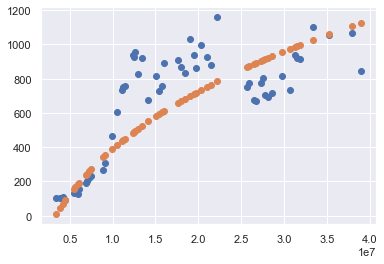

In [32]:
plt.scatter(df_features_test["Delta^3"], df_target_test)
plt.scatter(df_features_test["Delta^3"], pred)

In [33]:
# TESTS
target = prepare_target(df_target_test)

mse = mean_squared_error(target, pred)
print(mse, "mean squared error")

42773.15645993624 mean squared error


## Multiple Linear Regression
<a id="multi"></a>

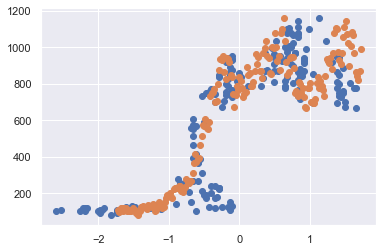

In [34]:
df_features, df_target = get_features_targets(df,["Transit", "Delta"],["ICU admissions"])

df_features = normalize_z(df_features)

plt.scatter(df_features["Transit"], df_target)
plt.scatter(df_features["Delta"], df_target)


[[608.34541567]
 [ 66.7350435 ]
 [256.94147874]]


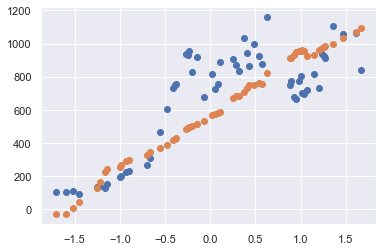

In [35]:
df_features_third = df_features

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_third, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((3,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

print(beta)
pred = predict(df_features_test, beta)
# print(pred)

plt.scatter(df_features_test["Delta"], df_target_test)
plt.scatter(df_features_test["Delta"], pred)

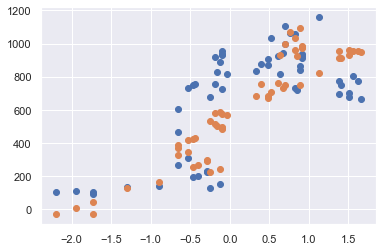

In [36]:
plt.scatter(df_features_test["Transit"], df_target_test)
plt.scatter(df_features_test["Transit"], pred)

In [37]:
# TESTS
target = prepare_target(df_target_test)

mse = mean_squared_error(target, pred)
print(mse, "mean squared error")

46208.684609792086 mean squared error


## Model Evaluation

Steps taken to improve accuracy of model
1. Logging features
2. Adjusting the power of polynomial linear regression model
3. Research for other possible features

